# Making Decision with Hidden Information: Hidden Markov Models

# Markov Models

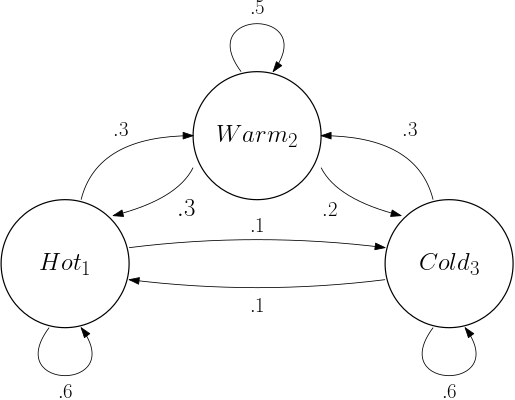

Transition matrix:

$M = \left( \begin{array}{ccc} .6 & .3 & .1 \\ .3 & .5 & .2 \\ .1 & .3 & .6 \end{array}\right)$

Initial probabilities

If we have no information about the recent weather, then 35% of the time it
is hot, 37.5% it is warm and 27.5% it is cold.

$\pi = \left( \begin{array}{c} .350 \\ .375 \\ .275 \end{array} \right)$

# Add Observations

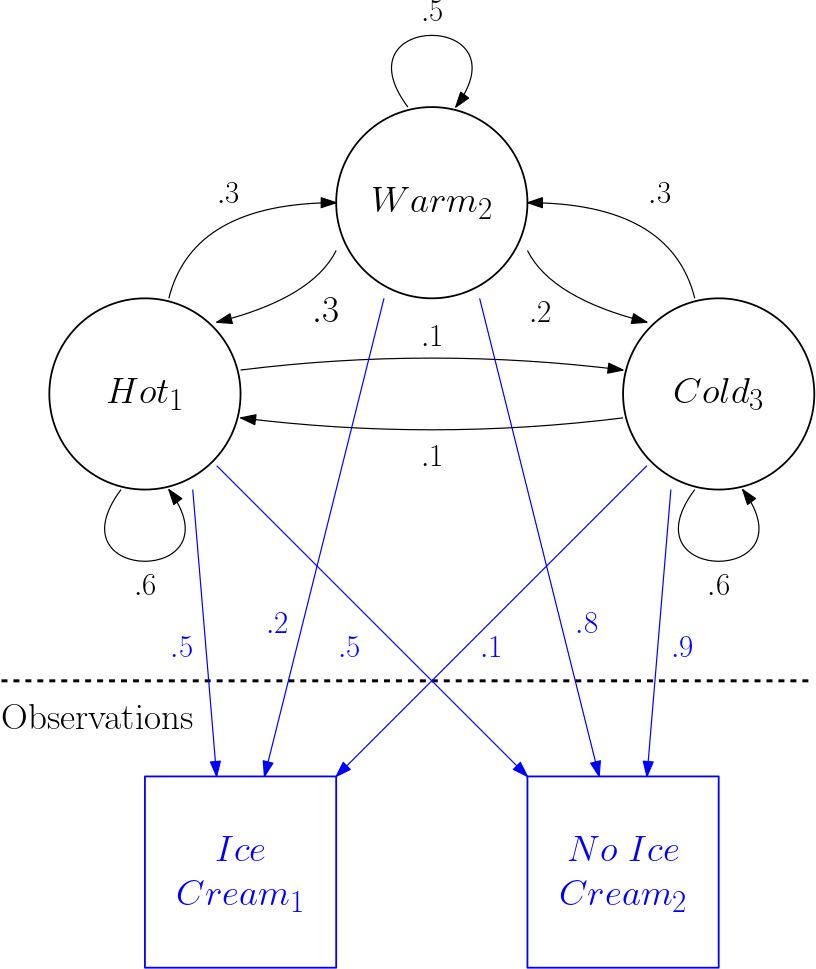

$B = \left( \begin{array}{cc} .5 & .5 \\ .2 & .8 \\ .1 & .9 \end{array} \right)$

# Can we figure out what's happening just from a sequence of observations?

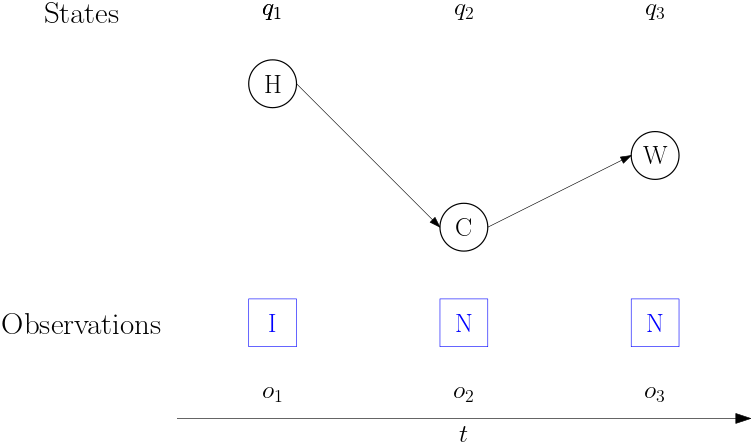

Given a sequence of observations $o_1 o_2 \ldots o_t$ can we ...


*  **Filter** Find $P(q_t | o_1 o_2 \ldots o_t)$  (i.e. What's going on now) 
*  **Predict** Find $P(q_{t+k} | o_1 o_2 \ldots o_t)$ (i.e. What's going to happen)
*  **Smooth** Find $P(q_k | o_1 o_2 \ldots o_t)$ for $1 \le k < t$ (i.e. What happened knowning the full observation sequence) 
*  **Explain** What is the most likely sequence of state $q_1 q_2 \ldots q_t$ given the observations $o_1 o_2 \ldots o_t$
*  **Learn** Find the HMM just from a sequence of observations



# HMM's in Python

First, we will load some Python modules

In [ ]:
!pip install hmmlearn           # Not a Python command.  It installs the library on Colab
from hmmlearn import base, hmm  # Module for HMMs
from matplotlib import pyplot   # A plotling module similar to MatLab's plot
import numpy                    # A package for arrays, matrices and linear algebra
from math import *              # Math might help

     |████████████████████████████████| 368kB 2.9MB/s 


In [ ]:
model = hmm.MultinomialHMM(n_components=3)  # Create a HMM with 3 internal states
model.n_features = 2  # Number of observed states
model.startprob_ = numpy.array([.350, .375, .275])
model.transmat_ = numpy.array([ [.6, .3, .1], [.3, .5, .2], [.1, .3, .6]])
model.emissionprob_ = numpy.array([ [.5, .5], [.2, .8], [.1, .9]])
print(model.startprob_)
print(model.transmat_)
print(model.emissionprob_)

[0.35  0.375 0.275]
[[0.6 0.3 0.1]
 [0.3 0.5 0.2]
 [0.1 0.3 0.6]]
[[0.5 0.5]
 [0.2 0.8]
 [0.1 0.9]]


In [ ]:
observations = 'ININNINNNN'

# Convert observations to a column vector of 0's and 1's
obsSequence = numpy.array([ ['IN'.find(c)] for c in observations ])

# How to Filter

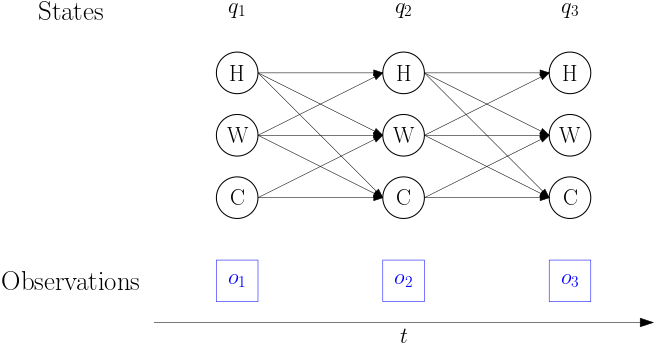

Do we have to consider every single state sequence?

There are exponentially many of them!  Instead use ***dynamic programming***!

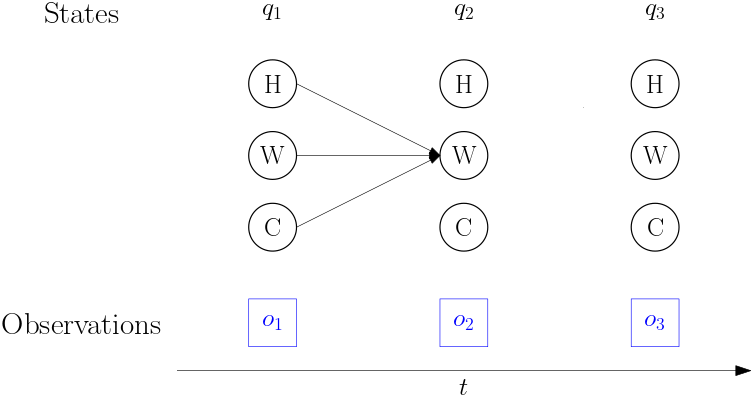

Let $\widetilde\alpha_k(i) = P(q_k=i, o_1, \ldots, o_k)$.  The probability that the internal state is $i$ assuming that we have the sequence of observations is
$$\alpha_k(i) = \frac{\widetilde\alpha_k(i)}{\sum_j \widetilde\alpha_k(j)}$$

Base case: $\widetilde\alpha_1(i) = P(q_1=i, o_1) = \pi_i B_{io_1}$

Then $\widetilde\alpha_k(i) = P(q_k=i, o_1, \ldots, o_k)$

> $= \sum_j P(q_k=i, q_{k-1}=j, o_1, \ldots, o_k)$

> $= \sum_j P(q_{k-1}=j, o_1, \ldots, o_{k-1}) a_{ji} b_{i o_k}$

> $= \left( \sum_j \widetilde\alpha_{k-1}(j) a_{ji} \right) b_{i o_k}$

This is called the **forward** algorithm.

In [ ]:
def alpha(k):
  alphatilde = numpy.multiply(model.startprob_, numpy.transpose(model.emissionprob_[:,obsSequence[1]]))[0]
  alpha = numpy.divide(alphatilde, sum(alphatilde))

  for j in range(1,k+1):
    alphatilde = numpy.multiply(numpy.dot(alpha, model.transmat_), numpy.transpose(model.emissionprob_[:,obsSequence[j]]))[0]
    alpha = numpy.divide(alphatilde, sum(alphatilde))

  return alpha

In [ ]:
filterResults = numpy.array([alpha(j) for j in range(len(observations))])
print(filterResults)

[[0.24221453 0.41522491 0.34256055]
 [0.20549867 0.41408332 0.38041801]
 [0.56545916 0.30321143 0.1313294 ]
 [0.32288104 0.42021451 0.25690445]
 [0.23879064 0.42470739 0.33650196]
 [0.58474835 0.29584841 0.11940325]
 [0.33033406 0.42041003 0.24925592]
 [0.24189833 0.42563919 0.33246248]
 [0.20707283 0.416886   0.37604117]
 [0.19207044 0.4106347  0.39729485]]


Filtered values only use the past to explain the current


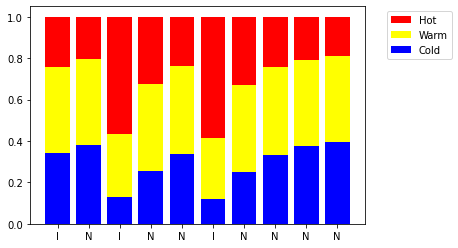

In [ ]:
f_hot = filterResults[:,0]
f_warm = filterResults[:,1]
f_cold = filterResults[:,2]
ind = [i for i,_ in enumerate(observations)]

pyplot.bar(ind, f_hot, color='red', label='Hot', bottom = f_warm+f_cold)
pyplot.bar(ind, f_warm, color='yellow', label='Warm', bottom = f_cold)
pyplot.bar(ind, f_cold, color='blue', label='Cold')
pyplot.legend(loc='upper left', bbox_to_anchor=(1.05,1))
pyplot.xticks(ind, list(observations))
print('Filtered values only use the past to explain the current')

In [ ]:
filterMaxs = numpy.argmax(filterResults, axis=1)
print(filterMaxs)
print(''.join(['HWC'[x] for x in filterMaxs]))

[1 1 0 1 1 0 1 1 1 1]
WWHWWHWWWW


# What is most likely to occurred knowing the full sequence of observations?

**Goal** Find $P(q_k = i \ | \ o_1, \ldots o_t)$

Similar to the forward algorithm there is a **backward algorithm** to find

> $\beta_k(i) = P(o_{k+1}, \ldots o_k \ | \ q_k = i)$

This is the probability that if the hidden state at time $k$ is $i$ that we observe $o_{k+1}, \ldots o_k$
afterwards.  This is derived similarly to the formula
for $\alpha_k(i)$.

$$P(q_k = i \ | \ o_1, \ldots o_t) = \frac{\alpha_k(i) \beta_k(i)}{\sum_j \alpha_k(j) \beta_k(i)}$$

Essential, we see how likely the observation sequence up to time $k$ is to leed to state $i$ and multiply by how likely it is that if we are in state $i$ at time $k$ we see the rest of the observations.

Fortunately, the hmmlearn library can do smoothing for us.

In [ ]:
# Find the probability of the internal states at each point in time
smoothingResults = model.predict_proba(obsSequence)
print(smoothingResults)

[[0.62637822 0.27817118 0.0954506 ]
 [0.43946342 0.40583118 0.15470539]
 [0.590248   0.29672438 0.11302762]
 [0.34121974 0.43069089 0.22808937]
 [0.32433663 0.43727902 0.23838436]
 [0.51465561 0.32182805 0.16351634]
 [0.26677693 0.42048529 0.31273778]
 [0.19318865 0.41368551 0.39312584]
 [0.17504906 0.40769476 0.41725618]
 [0.1922655  0.41073213 0.39700236]]


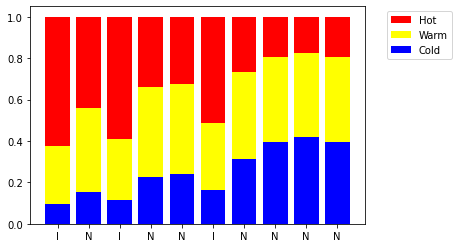

In [ ]:

s_hot = smoothingResults[:,0]
s_warm = smoothingResults[:,1]
s_cold = smoothingResults[:,2]
ind = [i for i,_ in enumerate(observations)]

pyplot.bar(ind, s_hot, color='red', label='Hot', bottom = s_warm+s_cold)
pyplot.bar(ind, s_warm, color='yellow', label='Warm', bottom = s_cold)
pyplot.bar(ind, s_cold, color='blue', label='Cold')
pyplot.legend(loc='upper left', bbox_to_anchor=(1.05,1))
_ = pyplot.xticks(ind, list(observations))

In [ ]:
smoothingMaxs = numpy.argmax(smoothingResults, axis=1)
print(smoothingMaxs)
print(''.join(['HWC'[x] for x in smoothingMaxs]))

[0 0 0 1 1 0 1 1 2 1]
HHHWWHWWCW


# Viterbi algorithm

Finds the most likely sequence of states that explains the observations.

**Idea** Consider partial paths (dynamic programming again!).  These paths consider both past and future observations.

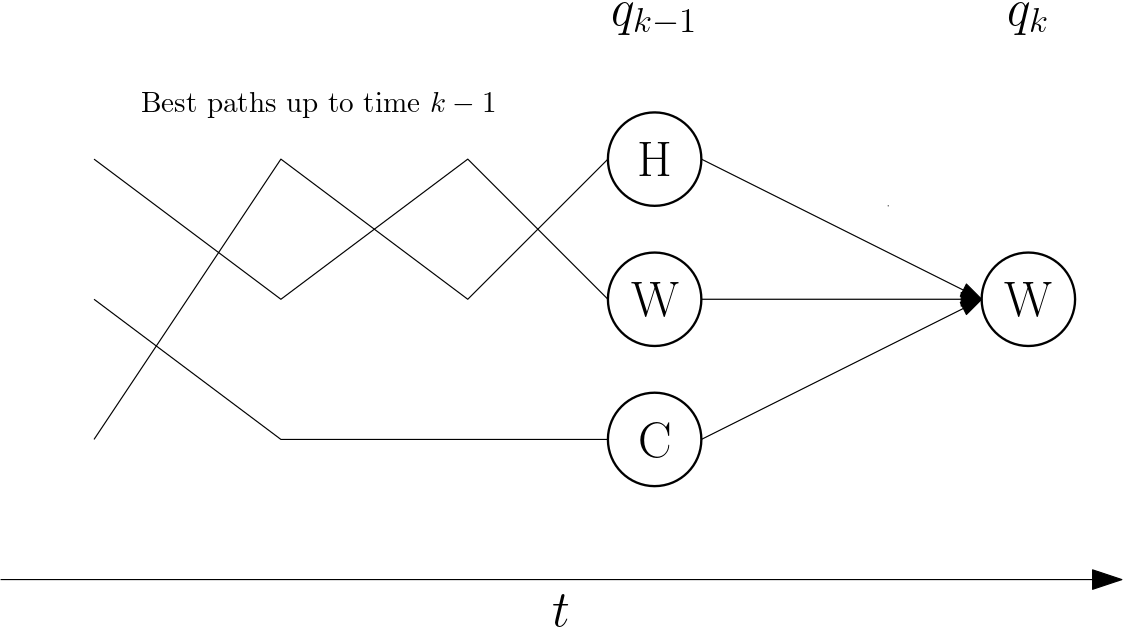

The best path going through a particular state at time $k$, must follow one of the best paths to the states at time $k-1$.

In [ ]:
logProb, viterbi = model.decode(obsSequence)
print(exp(logProb))
print(viterbi)
print(''.join(['HWC'[x] for x in viterbi]))

6.531839999999973e-06
[0 0 0 0 0 0 1 1 1 1]
HHHHHHWWWW


# Comparison of results

Observations:          ININNINNNN
Filtering most likely: WWHWWHWWWW
Smoothing most likely: HHHWWHWWCW
Most likely sequence:  HHHHHHWWWW


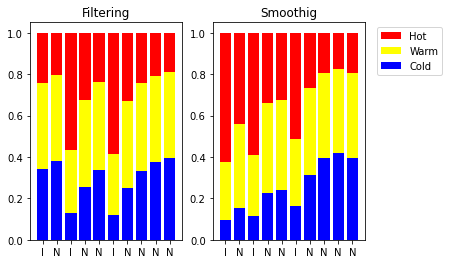

In [ ]:
pyplot.subplot(1,2,1)
pyplot.bar(ind, f_hot, color='red', label='Hot', bottom = f_warm+f_cold)
pyplot.bar(ind, f_warm, color='yellow', label='Warm', bottom = f_cold)
pyplot.bar(ind, f_cold, color='blue', label='Cold')
pyplot.xticks(ind, list(observations))
pyplot.title('Filtering')
pyplot.subplot(1,2,2)
pyplot.bar(ind, s_hot, color='red', label='Hot', bottom = s_warm+s_cold)
pyplot.bar(ind, s_warm, color='yellow', label='Warm', bottom = s_cold)
pyplot.bar(ind, s_cold, color='blue', label='Cold')
pyplot.legend(loc='upper left', bbox_to_anchor=(1.05,1))
pyplot.xticks(ind, list(observations))
pyplot.title('Smoothig')
print('Observations:         ', observations)
print('Filtering most likely:', ''.join(['HWC'[x] for x in filterMaxs]))
print('Smoothing most likely:', ''.join(['HWC'[x] for x in smoothingMaxs]))
print('Most likely sequence: ', ''.join(['HWC'[x] for x in viterbi]))

# Learning the HMM using Baum-Welch

1. Start with random transition and observation matrices.
2. Fix your transition matrix and find the observation (emmision) matrix that best describes our observations.
3.  Fix you observation matrix and find the observation matrix that best descibes your observations.
Repeat steps 2 and 3 many times to improve you guess.

In [ ]:
learnedModel = hmm.MultinomialHMM(n_components=3)  # Still has 3 internal states
learnedModel.n_features = 2  # And 2 observed features
learnedModel.n_iter = 10000
learnedModel.tol = .01
learnedModel.verbose = False
class ThresholdMonitor(base.ConvergenceMonitor):
  @property
  def converged(self):
    return (self.iter == self.n_iter or self.history[-1] >= self.tol)
learnedModel.monitor_ = ThresholdMonitor(learnedModel.n_iter, learnedModel.tol, learnedModel.verbose)
learnedModel.fit(obsSequence)

Fitting a model with 11 free scalar parameters with only 10 data points will result in a degenerate solution.


MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=3,
               n_iter=10000, params='ste',
               random_state=RandomState(MT19937) at 0x7FDC528B5780,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
               verbose=False)

In [ ]:
# Create a longer sequence of observations from our original model
longSequence = numpy.transpose(model.sample(1000)[0])

In [ ]:
# Create a longer sequence of observations from our original model
x = learnedModel.fit(longSequence)
print('Original and learned transition probabilities')
print(model.transmat_)
print(learnedModel.transmat_)
print('Original and learned observation probabilities')
print(model.emissionprob_)
print(learnedModel.emissionprob_)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
